In [17]:
%matplotlib inline
import matplotlib.tri as tri
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.animation
import numpy as np
import math
import os
import base64

ň = None
s2 = math.sqrt(2)
s3 = math.sqrt(3)
s6 = math.sqrt(6)
pp = np.pi/2 #pípůl
pt = np.pi/3 #pítřeť

from IPython.display import HTML
print(matplotlib.__version__)
print(dict(matplotlib.animation.writers.avail))

2.1.2
{'avconv': <class 'matplotlib.animation.AVConvWriter'>, 'html': <class 'matplotlib.animation.HTMLWriter'>, 'avconv_file': <class 'matplotlib.animation.AVConvFileWriter'>, 'imagemagick': <class 'matplotlib.animation.ImageMagickWriter'>, 'imagemagick_file': <class 'matplotlib.animation.ImageMagickFileWriter'>}


In [112]:
def kpointplanewaves(phases = (0,0,0,0,0,0), facs = (1,1,1,1,1,1), Kmultiplier=1, ascale=40, wscale=25, sscale=100, 
                     gphase=0, rot=False, showcontribs=False, noplot=False, transversal=True, magfield=None, pointmagfield=False, magcmap = 'bwr'):
    if magfield is None:
        magfield = transversal
    facs = np.array(facs)
    phases = np.array(phases,dtype=float)
    xl = 4.5 # plot dimensions
    yl = 3
    diaghalf = (xl**2+yl**2)**0.5
    mgdens=30
    hsl = 1 # hexagon side length
    n1 = 5
    n2 = 5
    b1 = np.array((hsl*s3,0)) if rot else np.array((0,hsl*s3))
    b2 = np.array((hsl*s3/2,-hsl*3/2)) if rot else np.array((hsl*3/2,hsl*s3/2))
    Ashift = np.array((0,hsl)) if rot else np.array((-hsl,0)) 
    Bshift = np.array((0,-hsl)) if rot else np.array((hsl,0))
    
    
    if magfield:
        nn = np.arange(-mgdens*diaghalf*s3/hsl,mgdens*diaghalf*s3/hsl)
        maggrid = (nn[:,ň,ň]*b1[ň,ň,:] + nn[ň,:,ň]*b2[ň,ň,:]) / mgdens
        maggrid = maggrid[(maggrid[:,:,0] >= -xl) * (maggrid[:,:,0] <= xl) * 
                          (maggrid[:,:,1] >= -yl) * (maggrid[:,:,1] <= yl)]

    Asites = np.arange(-n1,n1)[:,ň,ň] * b1[ň,ň,:] + np.arange(-n2,n2)[ň,:,ň] * b2[ň,ň,:] + Ashift
    Asites = np.reshape(Asites,(np.prod(Asites.shape[:-1]), Asites.shape[-1]))
    Bsites = Asites - Ashift + Bshift

    Klen = 4*np.pi/3/s3/hsl*Kmultiplier
    wi = np.arange(6)
    Kangle = np.pi*(1/6-rot/2+wi/3)
    upangle = Kangle + pp*transversal
    K = Klen * np.stack((np.cos(Kangle),np.sin(Kangle)), axis=-1)
    up = np.stack((np.cos(upangle),np.sin(upangle)), axis=-1)
    if not noplot:
        f, ax = plt.subplots(1)
    else:
        f = None
        ax = None
    
    if not noplot:
        for i in range(3): # osy
            ax.plot(*np.transpose([-4*K[i],4*K[i]]),ls='-',c='k')
    iticks = np.arange(-32*n1,32*n1)[ň,:,ň]*K[:,ň,:]  / Klen * s3/32 # [wi, site, x]
    scale_units = 'width'
    if magfield:
            triang = tri.Triangulation(maggrid[:,0], maggrid[:,1])
    
    gphase = np.array(gphase)
    animate = (gphase.ndim > 0)
    gphase = np.ravel(gphase)
    nphases = gphase.size
    origphases = phases
    
    # zeroth index is global phase gpi
    phases = phases[ň,:] + gphase[:,ň] # [gpi, wi]
    iphases = np.sum(iticks * K[:,ň,:], axis=-1 )-phases[:,:,ň] # [wi, site, /x/] * [wi, ň,/x/] - [gpi,wi, ň,] ~ [gpi,wi, site]
    phaseA = np.tensordot(K, Asites, axes=(-1,-1))-phases[:,:,ň] # ([wi,/x/]*[site,/x/])-[gpi, wi, ň] ~ [gpi,wi,site]
    phaseB = np.tensordot(K, Bsites, axes=(-1,-1))-phases[:,:,ň]
    iwaves = (np.exp(1j*iphases)[:,:, :, ň] * up[:, ň, :] * facs[:, ň, ň]).real # exp[gpi,wi,site,ň]*[wi,ň,x]*[wi,ň,ň] ~ [gpi, wi,site,x]
    Awave = np.sum(np.exp(1j*phaseA)[:,:, :, ň] * up[:, ň, :] * facs[:, ň, ň], axis=1).real # [gpi,/wi/,site,ň]*[/wi/,ň,x]*[/wi/,ň,ň] ~ [gpi,site,x]
    AwaveH = np.sum(np.exp(1j*phaseA)[:, :, :] * facs[:, ň], axis=1).imag
    Awave*=(abs(Awave)>1e-13)
    Bwave = np.sum(np.exp(1j*phaseB)[:,:, :, ň] * up[:, ň, :] * facs[:, ň, ň], axis=1).real
    BwaveH = np.sum(np.exp(1j*phaseB)[:, :,:] * facs[:, ň], axis=1).imag
    Bwave*=(abs(Bwave)>1e-13)
    if magfield:
        magphases = np.tensordot(K, maggrid, axes=(-1,-1)) - phases[:,:,ň] # [gpi,wi, magsite]
        magwaves = np.sum((np.exp(1j*magphases)[:,:,:] * facs[:,ň]).imag, axis=1)# [gpi, magsite]

    if pointmagfield:
        sites = np.concatenate((Asites, Bsites))
        waveH = np.concatenate((AwaveH, BwaveH), axis=1)
    
    if not noplot:
        gpi = 0
        if magfield:
            magcax = ax.tripcolor(triang, magwaves[gpi], cmap=magcmap, shading='gouraud')
            
        
        pwax = ax.quiver(iticks[:,:,0], iticks[:,:,1],
                   iwaves[gpi,:,:,0],
                   iwaves[gpi,:,:,1],
                 lw=0.2, color= 'lime', headwidth=0, scale_units=scale_units, scale = wscale)

        #print (abs(waveH)*sscale)
        ax.scatter(Asites[:,0], Asites[:,1], marker='+', c='orange')
        ax.scatter(Bsites[:,0], Bsites[:,1], marker='+', c='magenta')
        if pointmagfield:
            pmfcax = ax.scatter(sites[:,0], sites[:,1], marker='o', s=abs(waveH[gpi])*sscale,
                   c=np.where(waveH[gpi]>0,'pink','lightblue') )
        Acax = ax.quiver(Asites[:,0],Asites[:,1],Awave[gpi,:,0],Awave[gpi,:,1],headwidth=1, scale_units = scale_units, scale=ascale)
        Bcax = ax.quiver(Bsites[:,0],Bsites[:,1],Bwave[gpi,:,0],Bwave[gpi,:,1],headwidth=1, scale_units = scale_units, scale=ascale)
        if showcontribs:
                cAcax = ax.quiver(Asites[ň,:,0],Asites[ň,:,1],((np.exp(1j*phaseA)[gpi, :, :, ň] * up[:, ň, :] * facs[:, ň, ň])[:,:,0]).real,
                                                  ((np.exp(1j*phaseA)[gpi, :, :, ň] * up[:, ň, :] * facs[:, ň, ň])[:,:,1]).real,headwidth=1, scale_units = scale_units, scale=ascale, color='green' if (i < 3) else 'red')
                cBcax = ax.quiver(Bsites[ň,:,0],Bsites[ň,:,1],((np.exp(1j*phaseB)[gpi, :, :, ň] * up[:, ň, :] * facs[:, ň, ň])[:,:,0]).real,
                                                  ((np.exp(1j*phaseB)[gpi, :, :, ň] * up[:, ň, :] * facs[:, ň, ň])[:,:,1]).real,headwidth=1, scale_units = scale_units, scale=ascale, color='green' if (i < 3) else 'red')

        ax.set_xlim(-xl,xl)
        ax.set_ylim(-yl,yl)
        ax.set_title('%.3f pi' % (gphase[gpi]/np.pi))
    if animate:
        def update_anim(frame):
            gpi = frame % nphases
            toreturn = list()
            if magfield:
                #nonlocal magcax
                #ax.remove(magcax)
                magcax.set_array(magwaves[gpi])
                toreturn.append(magcax)
            if pointmagfield:
                pmfcax.set_sizes(abs(waveH[gpi])*sscale)
                pmfcax.set_colors(np.where(waveH[gpi]>0,'pink','lightblue'))
                toreturn.append(pmfcax)
            pwax.set_UVC(iwaves[gpi,:,:,0], iwaves[gpi,:,:,1])
            Acax.set_UVC(Awave[gpi,:,0],Awave[gpi,:,1])
            Bcax.set_UVC(Bwave[gpi,:,0],Bwave[gpi,:,1])
            toreturn.extend([pwax,Acax,Bcax])
            if showcontribs:
                cAcax.set_UVC(((np.exp(1j*phaseA)[gpi, :, :, ň] * up[:, ň, :] * facs[:, ň, ň])[:,:,0]).real,
                              ((np.exp(1j*phaseA)[gpi, :, :, ň] * up[:, ň, :] * facs[:, ň, ň])[:,:,1]).real)
                cBcax.set_UVC(((np.exp(1j*phaseB)[gpi, :, :, ň] * up[:, ň, :] * facs[:, ň, ň])[:,:,0]).real,
                              ((np.exp(1j*phaseB)[gpi, :, :, ň] * up[:, ň, :] * facs[:, ň, ň])[:,:,1]).real)
                toreturn.extend([cAcax, cBcax])
            ax.set_title('%.3f pi' % (gphase[gpi]/np.pi))
            toreturn.append(ax)
            return toreturn
        anim = matplotlib.animation.FuncAnimation(f, update_anim, interval=100, frames=nphases, blit=False)
        #HTML(anim.to_html5_video())
    else:
        anim = None
    return {'Awave':Awave,'Bwave':Bwave,'AwaveH':AwaveH, 'BwaveH':BwaveH,'Asites':Asites, 'Bsites':Bsites,'iticks': iticks,'iwaves': iwaves,
            'f': f, 'ax': ax, 'anim': anim}

bfacs = {
    'ka1' : np.array((1/s3, 0, 1/s3, 0, 1/s3, 0,)),
    'ke1a' : np.array((-1/s2, 0,1/s2, 0, 0, 0)),
    'ke1b' : np.array((-1/s6, 0,-1/s6, 0,2/s6, 0, ))
    #'ka1' : np.array((1/s3, 0, 1/s3, 0, 1/s3, 0,)),
    #'ke1a' : np.array((1/s2, 0, 0, 0, -1/s2, 0,)),
    #'ke1b' : np.array((-1/s6, 0, 2/s6, 0, -1/s6, 0,))
}

In [113]:
def kptf(phases = (0,0,0,0,0,0), facs = (1,1,1,1,1,1), Kmultiplier=1, ascale=40, wscale=25, sscale=100, gphase=0, 
         rot=False, showcontribs=False, noplot=False, transversal=True):
    facs = np.array(facs)
    phases = np.array(phases,dtype=float)
    phases += gphase
    hsl = 1 # hexagon side length
    b1 = np.array((hsl*s3,0)) if rot else np.array((0,hsl*s3))
    b2 = np.array((hsl*s3/2,-hsl*3/2)) if rot else np.array((hsl*3/2,hsl*s3/2))
    
    Klen = 4*np.pi/3/s3/hsl*Kmultiplier
    wi = np.arange(6)
    Kangles = np.pi*(1/6-rot/2+wi/3)
    upangles = Kangles+pp*transversal# np.pi*(wi/3+rot/2)
    sitangles = np.pi*(wi/3+rot/2)
    K = Klen * np.stack((np.cos(Kangles),np.sin(Kangles)), axis=-1) #[wi,x] #Klen * np.stack((np.cos(np.pi*(1/6-rot/2+wi/3)),np.sin(np.pi*(1/6-rot/2+wi/3))), axis=-1) #[wi,x]\
    up = np.stack((np.cos(upangles),np.sin(upangles)), axis=-1)
    sites = hsl * np.stack((np.cos(sitangles), np.sin(sitangles)),axis=-1)
    phase = np.tensordot(K, sites, axes=(-1,-1))-phases[:,ň] # ([wi,/x/]*[site,/x/])-[wi, ň] ~ [wi,site]
    wave = np.sum(np.exp(1j*phase)[:, :, ň] * up[:, ň, :] * facs[:, ň, ň], axis=0) # [/wi/,site,ň]*[/wi/,ň,x]*[/wi/,ň,ň] ~ [site,x]
    wave*=(abs(wave)>1e-13)
    tf = np.sum(wave[ň,:,:] * np.exp(-1j*np.tensordot(K,sites, axes=(-1,-1)))[:,:,ň],axis=1)
    if not noplot:
        scale_units='width'
        f, ax = plt.subplots(1)
        ax.quiver(K[:,0], K[:,1], tf[:,0].real, tf[:,1].real,scale_units = scale_units, scale=ascale, color='blue', pivot='mid' )
        ax.quiver(K[:,0], K[:,1], tf[:,0].imag, tf[:,1].imag,scale_units = scale_units, scale=ascale, color='red', pivot='mid' )
        ax.set_aspect('equal')
        ax.set_xlim([-3*hsl,3*hsl])
        ax.set_ylim([-3*hsl,3*hsl])
        return (tf, f, ax)
    return (tf) # [ki,x]

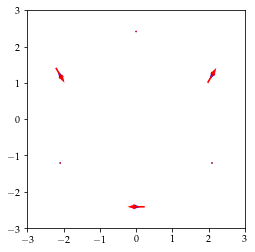

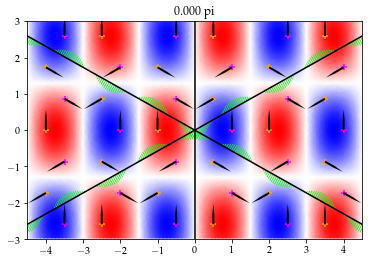

In [114]:
# jenom K vlna (ne K')
typ = 'ke1a'

kptf(gphase=pt, facs=bfacs[typ], wscale=20, transversal=False);
anim=kpointplanewaves(gphase=np.linspace(0,2*np.pi,15)
                 , facs=bfacs[typ], wscale=20, ascale=10, transversal=True)['anim']
#HTML(anim.to_html5_video())
#plt.draw()
#plt.show()
anim.save('/tmp/temp.mp4', fps=15, writer='avconv', codec='libx264')
with open('/tmp/temp.mp4', 'rb') as f:
    video_tag = '<video controls alt="test" src="data:video/x-m4v;base64,{0}">'.format(base64.b64encode(f.read()).decode('utf-8'))
HTML(video_tag)
#anim.save('/tmp/test.gif', writer='imagemagick')


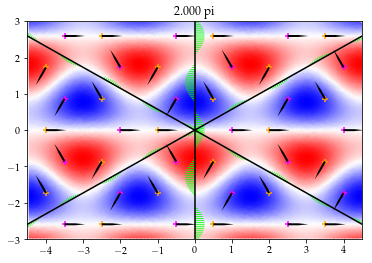

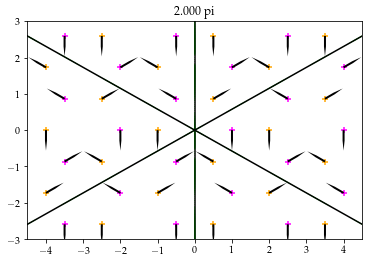

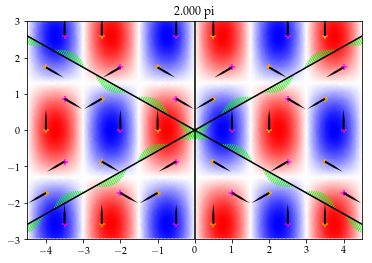

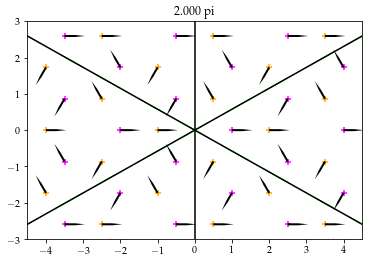

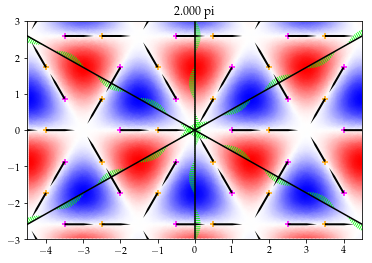

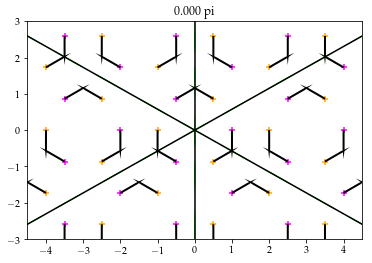

In [116]:
for typ in bfacs.keys():
  for transversal in [True, False]:
    anim=kpointplanewaves(gphase=np.linspace(0,2*np.pi,150)
                 , facs=bfacs[typ], wscale=20, ascale=10, transversal=transversal)['anim']
    anim.save('/home/mmn/hexx/K1_%s_%s.gif' % ('trans' if transversal else 'long', typ), fps=15, writer='imagemagick',# codec='libx264'
             )

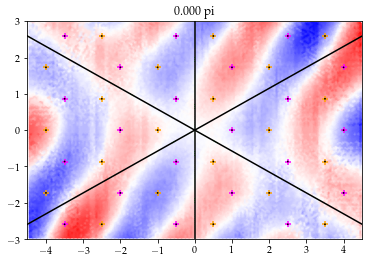

In [122]:
for relphase in [0.0,]:
  facs = np.array((1/s3, 0, 1/s3, 0, 1/s3, 0,)) + np.exp(1j*relphase)*np.array((0,1/s3, 0, 1/s3, 0, 1/s3,))
  for transversal in [True,]:
    anim=kpointplanewaves(gphase=np.linspace(0,2*np.pi,150)
                 , facs=facs, wscale=50, ascale=25, transversal=transversal)['anim']
    anim.save('/home/mmn/hexx/K1+K1p_%s_%s_relphase%.3fpi.mp4' % ('trans' if transversal else 'long', 'a1', relphase/np.pi), fps=15, writer='avconv', codec='libx264'
             )

In [196]:
# (a) + (d), levotočivý
transversal=True
typ = 'ke1a'
rot = False
gphase = np.linspace(0,2*np.pi,80)
for index, delay in enumerate(gphase):
    _,_,_,_,_,_,_,_, f, _ = kpointplanewaves(gphase=delay, 
                               facs=bfacs[typ], rot=rot, transversal=transversal)
    plt.savefig('/tmp/%s_%s%s_frame%03i.png'%(,index)
    plt.close(f)

In [226]:
bpath='/m/home/home4/46/necadam1/unix/hexx/projs/'
gphase = np.linspace(0,2*np.pi,40,endpoint=False)
for rot in (True,False):
    for polang in (-60,-45,-30,0,30,45,60,90):
        os.makedirs('%s%s%d/src' % (bpath,'rot/' if rot else 'base/',polang), exist_ok=True)
        pa = polang * np.pi / 180
        for index, delay in enumerate(gphase):
            for typ in 'c':#('a','d','b','adl','adr'):
                f, ax = kpointplanewaves_proj(gphase=delay,
                            phases=bphases[typ],
                            facs=bfacs[typ], wscale=20, proj=(math.cos(pa),math.sin(pa)) ,rot=rot);
                plt.savefig('%s%s%d/src/%s_%03i.png'%(bpath,'rot/' if rot else 'base/',polang,typ,index))
                plt.close(f)

In [277]:
for typ in ('a','b','d'):
    ft,f,ax=kptf(gphase=pp,
                phases=bphases[typ],
                facs=bfacs[typ], wscale=20 ,
                      rot=False)
    plt.savefig('/tmp/ft_%s.pdf'%typ)
    plt.close(f)

for i in ${t}_frame*.png ; do  convert $i $(basename $i .png).gif ; done ; convert -delay 10 -loop 0 ${t}_frame*.gif ${t}.gif ; rm ${t}_frame*.*

for angle in */* ; do
  cd $angle
  for t in c; do # a d b adl adr; do
    for i in src/${t}_*.png; do
      convert $i $(basename $i .png).gif
    done
    convert -delay 10 -loop 0 ${t}_*.gif ${t}.gif
    rm ${t}_*.gif
  done  
  cd -  
done